Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---

# Introduction to Vision Transformers - Material
---

Transformer Models have revolutionized the field of machine learning, offering versatile architectures that excel in understanding complex patterns in data. Initially conceived for natural language processing tasks, Transformer Models are expanding their influence into other domains, including computer vision. These models are characterized by their unique ability to process sequential data, making them ideal for tasks involving time series, text, and even images.

In this notebook, we will explore the fundamentals of Transformer Models, focusing on their adaptability and efficiency in handling image data specifically. We will demonstrate how these powerful architectures can be adapted from language to vision tasks. **Vision Transformers (ViTs)** represent an intriguing adaptation of the Transformer framework, treating image patches as sequential tokens, thus allowing the model to capture complex spatial hierarchies and relationships within visual data.

This notebook will first cover the **theory and fundamentals** behind (Vision) Transformer models. What follows is a basic **implementation in PyTorch**.

---

## Overview

- [Additional ressources](#Additional-ressources)

    - [Classification](#Classification)
- [Implementation](#Implementation)
  - [Imports](#Imports)
  - [Parameters](#Parameters)
  - [Load data](#Load-data)
  - [Create model](#Create-model)
    - [Component 1: Embedding layer](#Component-1:-Embedding-layer)
    - [Component 2: Transformer Encoder](#Component-2:-Transformer-Encoder)
    - [Component 3: Classifier](#Component-3:-Classifier)
    - [Combining everything to a ViT](#Combining-everything-to-a-ViT)
  - [Training](#Training)
  - [Evalute](#Evaluate)
  - [Final Notes](#Final-Notes)
- [Learning Outcomes](#Learning-Outcomes)

---

## Theory
---

We will again adapt the excellent material provided by [Sagar Vinodababu](https://www.linkedin.com/in/svinodababu/) on [GitHub](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Transformers). Note that his introduction is based on **Natural Language Processing (NLP)** tasks, which is the original birthplace of the **transformer model**. At their core, transformer models rely on a **fundamental technique** that allow them to be very flexible for all kinds of tasks: **Attention**. This technique can be understood quite well by looking at the use case where it originated from. This understanding will be fully transferable to other tasks such as vision, audio, or video. If you think about it, you only need to transform data in the right way and everything could be text! Just as Sagar Vinodababu says in his tutorial:

> As in the original transformer paper, the context presented here is an NLP task – specifically the sequence transduction problem of machine translation. If you want to apply transformers to images, this tutorial is still a good place to learn about how they work.

This introduction will adapt the source material to exclude some NLP specifics and focus on the aspects that are concurrently used in vision transformers. The [implementation part](#Implementation) of this notebook will illustrate the necessary adapations to build a transformer model for vision use cases.

<span style="color:red"> If you do not understand some of the NLP specific terms like RNNs or word tokens, that is okay - do not dwell on it. Instead you should always ask yourself: <b>what if instead of words (or text), we would be dealing with pixels (or parts of an image) instead?</b></span>

### Concepts
* **Machine Translation.** This is the use case that inspired the creation of the transformer model. It is the process of using computer software to translate text or speech from one language to another. Before the inception of the transformer, this has been achieved by recurrent neural networks (RNNs). RNNs are deep learning models that can store information in an internal state and therefore process sequence data. This made RNNs very suitable for NLP, since text can easily be modeled as a sqeuence of words.
* **Transformer Network.** We have almost retired RNNs in favour of transformers, a new type of sequence model that possesses an unparalleled ability for representation and abstraction – all while being simpler, more efficient, and significantly more parallelizable. Today, the application of transformers is nearly universal, as their resounding success in NLP has also led to increasing adoption in computer vision tasks.
* **Multi-Head Scaled Dot-Product Attention.** At the heart of the transformer is the attention mechanism, specifically this flavour of attention. It allows the transformer to interpret and encode a sequence in a multitude of contexts and with an unprecedented level of nuance.
* **Encoder-Decoder Architecture.** Similar to RNNs, transformer models for sequence transduction typically consist of an encoder that encodes an input sequence, and a decoder that decodes it, token by token, into the output sequence. For vision transformers, we are mostly interested in the encoder part. In contrast to that, GenAI models like the GPT family employ a decoder-only architecture.
* **Positional Embeddings.** Unlike RNNs, transformers do not innately account for the sequential nature of text – they instead view such a sequence as a bag of tokens, or pieces of text, that can be freely mixed and matched with tokens from the same or from a different bag. The coordinates of tokens in a sequence are therefore manually injected into the transformer as one-dimensional vectors or embeddings, allowing the transformer to incorporate their relative positions into its calculations.

### Better than RNNs, but how?

Recurrent neural networks (RNNs) have long been a staple among NLP practitioners. They operate upon a sequence – you guessed it – sequentially. This isn't weird at all; it's even intuitive because that's how we do it too – we read text from one side to another.

## Implementation
---

Now we want to implement the ViT with all of its components from scratch in `PyTorch`: 

<img src="./img/vit.gif" width=800/>

Source: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)

One major disadvantage of transformers in general is their **size and computational requirements**. It is quite challenging to fit large, state-of-the-art transformer models into GPU-RAM and train them. This is why this implementation is very **minimal** for small image sizes with a very lean model (~210,000 parameters) and should be able to train with $<4$GB GPU-RAM while still achieving great results! It is based on [this](https://github.com/s-chh/PyTorch-Vision-Transformer-ViT-MNIST-CIFAR10) excellent code, which is faithful to the [original paper](https://arxiv.org/abs/2010.11929). Some implementation parts were also inspired by [Akshay Ballal](https://www.akshaymakes.com/blogs/vision-transformer) or [Nermin Nur Aydogan](https://github.com/nerminnuraydogan/vision-transformer).

### Imports

As always, we start with the imports:

In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
import os
import torch.nn as nn
from torch import optim
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import time

In [2]:
print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
if cuda_available:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if cuda_available else "cpu")
print(f'Using {device}')

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.3.0
cuda available: True
GPU: NVIDIA GeForce RTX 4090
Using cuda


### Parameters

We can set model and training hyperparameters here:

In [3]:
# Training parameters
EPOCHS = 10
WARMUP_EPOCHS = 10
BATCH_SIZE = 128
N_CLASSES = 10
N_WORKERS = 0
LR = 5e-4

# Data parameters
DATASET = 'fmnist'
IMAGE_SIZE = 28
PATCH_SIZE = 4
N_CHANNELS = 1
DATA_PATH = './data/'

# ViT parameters
EMBED_DIM = 64
N_ATTENTION_HEADS = 4
FORWARD_MUL = 2
N_LAYERS = 6
DROPOUT = 0.1
MODEL_PATH = './models'
LOAD_MODEL = False

### Load data

(original implementation in `data_loader.py`)

For this implementation example we want to use [fashion-mnist](https://github.com/zalandoresearch/fashion-mnist), which, as you already know from the introduction to PyTorch, is a more ecxiting drop-in replacement for the [mnist dataset](http://yann.lecun.com/exdb/mnist/). It contains grayscale images of size 28x28 pixels of fashion products in 10 classes. As mentioned earlier, the large computational requirements of transformer models restrict this introductory material towards smaller models and image sizes. 

The dataset can be imported as part of the `torchvision` module:

In [4]:
train_transform = transforms.Compose([transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
                              transforms.RandomCrop(IMAGE_SIZE, padding=2), 
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5])])
train = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=True, download=True, transform=train_transform)

test_transform = transforms.Compose([v2.Resize([IMAGE_SIZE, IMAGE_SIZE]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
test = datasets.FashionMNIST(os.path.join(DATA_PATH, DATASET), train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             num_workers=N_WORKERS,
                                             drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            num_workers=N_WORKERS,
                                            drop_last=False)

Next we can visualize some images together with the corresponding labels:

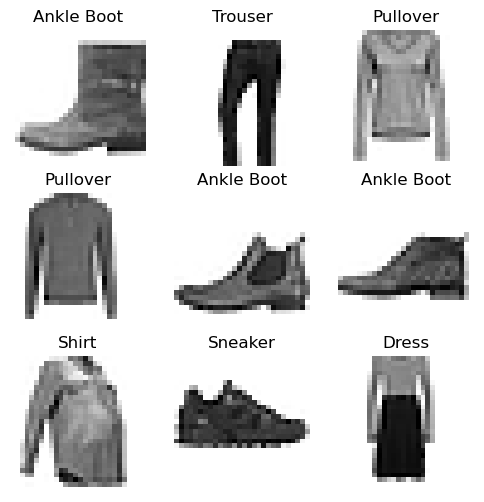

In [5]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (6,6))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train), size = (1,)).item()
    image, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray_r')
plt.show()

### Create model

(original implementation in `model.py`)

At a very broad level, a Vision Transformer model has three core components:
1. **Embedding layer**
2. **Transformer Encoder**
3. **Classification layer**

This implementation explains all of these components in detail. It uses the following abbreviations to make the code more readable:
* **B**: Batch size
* **C**: Number of input channels
* **IH**: Image height
* **IW**: Image width
* **P**: Patch size
* **E**: Embedding dimension
* **S**: Sequence length = IH/P * IW/P
* **Q**: Query Sequence length (same as S for self-attention)
* **K**: Key Sequence length (same as S for self-attention)
* **V**: Value Sequence length (same as S for self-attention)
* **H**: Number of heads
* **HE**: Head Embedding Dimension = E/H

#### Component 1: Embedding layer

The **Embedding layer** works in 3 steps:
1. Patch and embed images
2. Prepend a class token embedding vector to the learnable embeddings vectors
3. Adds a position embedding to the learnable embeddings

**Step 1: Patch and embed images**

Images need to be transformed to patches to be useable by a vision transformer. Instead of just slicing the image, a [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer is being used as this is much more computationally efficient. With the right **kernel size** and **stride**, this layer will produce patches naturally and embed them. In this example we have 28x28 pixels per image which we convert into 49 patches of size 4x4. Each patch is embedded into 64 dimensions and finally being flattened along a single vector:

<img src="./img/vit_patching.png" width=600/>

Inspired by [Akshay Ballal](https://www.akshaymakes.com/blogs/vision-transformer)

The **dimensions** can be seen with the following example:

In [6]:
# Get a single example image without transformations
vis_loader = torch.utils.data.DataLoader(dataset=train,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=N_WORKERS,
                                         drop_last=True)

images, _ = next(iter(vis_loader))

In [7]:
conv_layer = nn.Conv2d(in_channels = N_CHANNELS, out_channels = EMBED_DIM, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

In [8]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(images)
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the conv layer -> [1, 64, 7, 7] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 49, 64] <- [batch_size, num_of_patches, embedding_dims]


These patches can be visualized with the following code, but keep in mind, that the model internally uses `Conv2d` layers to do so!

Image shape:  (28, 28)
Number of patches: 49 with resolution (4, 4)
Patches shape:  (49, 4, 4, 1)
Flattened patches shape:  (49, 16)


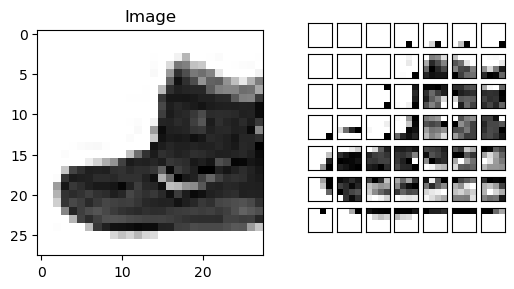

In [9]:
# convert to numpy array
x = np.array(images.squeeze())

# split image into patches using numpy
patches = x.reshape(x.shape[0]//PATCH_SIZE, PATCH_SIZE, x.shape[1]//PATCH_SIZE, PATCH_SIZE, N_CHANNELS).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE, N_CHANNELS)

# flatten patches
x_p = np.reshape(patches, (-1, PATCH_SIZE * PATCH_SIZE * N_CHANNELS))

# get number of patches
N = x_p.shape[0]

print('Image shape: ', x.shape)  # width, height, channel
print('Number of patches: {} with resolution ({}, {})'.format(N, PATCH_SIZE, PATCH_SIZE))
print('Patches shape: ', patches.shape)
print('Flattened patches shape: ', x_p.shape)

# visualize data
#
# display image and patches side-by-side

fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title='Image')

# display image
ax1.imshow(x,cmap='gray_r')

subgridspec = gridspec[1].subgridspec(8, 8, hspace=-0.8)

# display patches
for i in range(IMAGE_SIZE//PATCH_SIZE):
    for j in range(IMAGE_SIZE//PATCH_SIZE):
        num = i * (IMAGE_SIZE//PATCH_SIZE) + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num],cmap='gray_r')

**Step 2: Prepend a class token**

The *class token* is a special token added to the sequence of patch tokens. During the self-attention process, the class token interacts with all the patch tokens, aggregating information from them. This helps the model to gather a comprehensive understanding of the entire image. This token is learnable during training and it is initialized as `nn.Parameter` with `torch.zeros` in this example. It is prepended to the sequence of embedded patches with `torch.cat`:

In [10]:
class_token_embeddings = nn.Parameter(torch.zeros((1, 1,EMBED_DIM), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embedding_dims]')

Shape of class_token_embeddings --> [1, 1, 64] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 50, 64] <-- [batch_size, num_of_patches+1, embedding_dims]


**Step 3: Adding a position embedding**

To make patches position-aware, learnable *position embedding* vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighbouring ones have high similarity. This is again initialized as `torch.zeros` as `nn.Parameter`:

In [11]:
position_embeddings = nn.Parameter(torch.zeros((1, (IMAGE_SIZE // PATCH_SIZE) ** 2+1, EMBED_DIM ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')


Shape of position_embeddings --> [1, 50, 64] <-- [batch_size, num_patches+1, embeddings_dims]


**Combining all steps in the final Embedding layer**

In [12]:
class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        # Convolutional layer to convert image patches to embeddings
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding

        # Classification token, learnable parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        
        # Positional embeddings for each patch + 1 for the classification token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Convert image to patch embeddings
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)

        # Flatten the patch embeddings
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)

        # Transpose to match transformer input shape
        x = x.transpose(1, 2)  # B E S -> B S E 

        # Add classification token at the start of each sequence
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        
        # Add positional embeddings
        x = x + self.pos_embedding  # Adding positional embedding
        
        # Apply dropout
        x = self.dropout(x)
        return x

With this final step, we obtain the embeddings that have all the information that we want to pass on. Note also that we again use dropout for regularization purposes. We feed this resulting matrix into a stack of Transformer Encoders.

#### Component 2: Transformer Encoder

In this part we implement the self-attention mechanism and use it to build the transformer encoder block. The query, key, and value projections are implemented with three linear layers `nn.linear`. An **output projection layer** `self.out_projection` is defined to project the concatenated attention head outputs back to the original embedding dimension. In the forward function `forward(self,x)`, the input is **projected into queries, keys, and values, reshaped, and then transposed** to separate the attention heads. The query and key matrices are **multiplied to compute the raw attention scores**. The attention scores are **scaled** by the square root of the head embedding dimension for numerical stability. The scaled attention scores are passed through a **softmax function** to obtain attention weights. Finally, the attention weights are used to compute a **weighted sum** of the values.

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_attention_heads = n_attention_heads
        self.head_embed_dim = embed_dim // n_attention_heads

        # Linear layers for query, key, and value projections
        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads) # Queries projection
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)    # Keys projection
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)  # Values projection

        # Output projection layer
        self.out_projection = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        b, s, e = x.shape

        # Project inputs to queries, keys, and values
        xq = self.queries(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        xq = xq.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        xk = self.keys(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        xk = xk.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        xv = self.values(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        xv = xv.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        # Compute Attention presoftmax values
        xk = xk.transpose(-1, -2)  # B, H, K, HE -> B, H, HE, K
        x_attention = torch.matmul(xq, xk)  # B, H, Q, HE  *  B, H, HE, K -> B, H, Q, K

        # Scale presoftmax values for stability
        x_attention /= float(self.head_embed_dim) ** 0.5

        # Compute Attention Matrix
        x_attention = torch.softmax(x_attention, dim=-1)

        # Compute Attention Values
        x = torch.matmul(x_attention, xv)  # B, H, Q, K * B, H, V, HE -> B, H, Q, HE

        # Format the output
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(b, s, e)  # B, Q, H, HE -> B, Q, E
        x = self.out_projection(x)  # B, Q, E -> B, Q, E
        return x

What follows is a very straightforward implementation of the transformer encoder, using our `SelfAttention` class from above, together with the **layer normalization** `nn.LayerNorm`, **dropout** `nn.Dropout`, and **MLP layers** `nn.Linear`:

In [14]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        # Layer normalization and self-attention layer
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1 = nn.Dropout(dropout)

        # Feed-forward network layers
        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Apply self-attention with skip connection
        x = x + self.dropout1(self.attention(self.norm1(x)))

        # Apply feed-forward network with skip connection
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))
        return x

#### Component 3: Classifier

The classifier is composed of two hidden layers of a Multi-Layer Perceptron (MLP) `nn.Linear` with a tanh `nn.Tanh` activation function in-between the hidden layers. The final output of this classification head is the prediction for the image classification task. By using a *class token*, the model can directly map the summarized information to the desired output classes.

In [15]:
class Classifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # Linear layers for classification
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        # Use only the classification token for prediction
        x = x[:, 0, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

#### Combining everything to a ViT

We can now combine all these components to create the final ViT model:

In [16]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        # Embedding layer
        self.embedding = EmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)

        # Encoder layers
        self.encoder = nn.ModuleList([Encoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        
        # Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier
        self.classifier = Classifier(embed_dim, n_classes)

        # Initialize weights
        self.apply(vit_init_weights)

    def forward(self, x):
        # Apply embedding and encoder layers
        x = self.embedding(x)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)
        x = self.classifier(x)
        return x

Model weights are initialized as follows:

In [17]:
def vit_init_weights(m): 
    # Initialize weights for Conv2d and Linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    # Initialize weights for LayerNorm
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    # Initialize weights for EmbedLayer
    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)

We can now initialize the model:

In [18]:
# Initialize model
model = VisionTransformer(n_channels=N_CHANNELS, embed_dim=EMBED_DIM, 
                          n_layers=N_LAYERS, n_attention_heads=N_ATTENTION_HEADS, 
                          forward_mul=FORWARD_MUL, image_size=IMAGE_SIZE, 
                          patch_size=PATCH_SIZE, n_classes=N_CLASSES, dropout=DROPOUT)

In [19]:
# Load model parameters to cuda
model = model.to(device)

In [20]:
# Show model architecture
model

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

In [21]:
# Show number of model parameters
params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} learnable parameters")   

Model has 210,122 learnable parameters


As you can see, this configuration is very lean and uses quite a small number of parameters. Let's see if it still performs well on this dataset!

### Training

(original implementation in `solver.py`)

To following code to train the model is quite similar to code we have already seen and used in other lectures. One important difference is the usage of **schedulers** `optim.lr_scheduler.LinearLR` and `optim.lr_scheduler.CosineAnnealingLR`. These schedulers adapt the learning rate dynamically during training, which helps the model converge and achieve better performance (for object detection we adapted the learning rate by hand ...).

In [22]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [23]:
def test_dataset(model,loss_fn,loader):
    # Set Vision Transformer to evaluation mode
    model.eval()

    # Arrays to record all labels and logits
    all_labels = []
    all_logits = []

    # Testing loop
    for (x, y) in loader:
        x = x.cuda()

        # Avoid capturing gradients in evaluation time for faster speed
        with torch.no_grad():
            logits = model(x)

        all_labels.append(y)
        all_logits.append(logits.cpu())

    # Convert all captured variables to torch
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)
    all_pred = all_logits.max(1)[1]
    
    # Compute loss, accuracy and confusion matrix
    loss = loss_fn(all_logits, all_labels).item()
    acc = accuracy_score(y_true=all_labels, y_pred=all_pred)
    cm = confusion_matrix(y_true=all_labels, y_pred=all_pred, labels=range(N_CLASSES))

    return acc, cm, loss

def test(model,loss_fn,train_loader,test_loader):
    # Test using test loader
    acc, cm, loss = test_dataset(model,loss_fn,test_loader)
    print(f"Test acc: {acc:.2%}\tTest loss: {loss:.4f}")
    # Optional: print confusion matrix
    #print(cm)

    return acc, loss

In [24]:
# Train
iters_per_epoch = len(train_loader)

# Define optimizer for training the model
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# scheduler for linear warmup of lr and then cosine decay
linear_warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=1/WARMUP_EPOCHS, end_factor=1.0, total_iters=WARMUP_EPOCHS-1, last_epoch=-1)
cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-5)

# Variable to capture best test accuracy
best_acc = 0

train_start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    
    start_time = time.time()
    # Set model to training mode
    model.train()

    # Arrays to record epoch loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []

    # Loop on loader
    for i, (x, y) in enumerate(train_loader):

        # Push to GPU
        x, y = x.cuda(), y.cuda()

        # Get output logits from the model 
        logits = model(x)

        # Compute training loss
        loss = loss_fn(logits, y)

        # Updating the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch metrics
        batch_pred = logits.max(1)[1]
        batch_accuracy = (y==batch_pred).float().mean()
        train_epoch_loss += [loss.item()]
        train_epoch_accuracy += [batch_accuracy.item()]

        # Log training progress
        if i % 50 == 0 or i == (iters_per_epoch - 1):
            print(f'Ep: {epoch+1}/{EPOCHS}\tIt: {i+1}/{iters_per_epoch}\tbatch_loss: {loss:.4f}\tbatch_accuracy: {batch_accuracy:.2%}')

    end_time = time.time()

    # Print elapsed time for the epoch
    print(f"Training time for epoch {epoch} in minutes: {(end_time - start_time) / 60:.2f}")

    # Print train acc and loss
    print('------------')
    print(f"Train acc: {sum(train_epoch_accuracy)/iters_per_epoch:.2%}\tTrain loss: {sum(train_epoch_loss)/iters_per_epoch:.4f}")
    
    # Test the test set after every epoch
    test_acc, test_loss = test(model,loss_fn,train_loader,test_loader)
    
    # Capture best test accuracy
    best_acc = max(test_acc, best_acc)
    print(f"Best test acc: {best_acc:.2%}")

    # Save model if accuracy improves
    if test_acc >= best_acc:
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, "ViT_model.pt"))
        print('New model saved!\n')
    
    # Update learning rate using schedulers
    if epoch < WARMUP_EPOCHS:
        linear_warmup.step()
    else:
        cos_decay.step()

    # Update training progression metric arrays
    train_losses += [sum(train_epoch_loss)/iters_per_epoch]
    test_losses += [test_loss]
    train_accuracies += [sum(train_epoch_accuracy)/iters_per_epoch]
    test_accuracies += [test_acc]

train_end_time = time.time()
# overall training time
print(f"Overall training time in minutes: {(train_end_time - train_start_time) / 60:.2f} minutes on {device} for {EPOCHS} epochs")

Ep: 1/10	It: 1/468	batch_loss: 2.3056	batch_accuracy: 7.03%
Ep: 1/10	It: 51/468	batch_loss: 2.2498	batch_accuracy: 22.66%
Ep: 1/10	It: 101/468	batch_loss: 2.1745	batch_accuracy: 23.44%
Ep: 1/10	It: 151/468	batch_loss: 2.0838	batch_accuracy: 22.66%
Ep: 1/10	It: 201/468	batch_loss: 2.0024	batch_accuracy: 18.75%
Ep: 1/10	It: 251/468	batch_loss: 1.9290	batch_accuracy: 32.81%
Ep: 1/10	It: 301/468	batch_loss: 1.9089	batch_accuracy: 30.47%
Ep: 1/10	It: 351/468	batch_loss: 1.8333	batch_accuracy: 35.94%
Ep: 1/10	It: 401/468	batch_loss: 1.8103	batch_accuracy: 27.34%
Ep: 1/10	It: 451/468	batch_loss: 1.9060	batch_accuracy: 24.22%
Ep: 1/10	It: 468/468	batch_loss: 1.7949	batch_accuracy: 25.00%
Training time for epoch 0 in minutes: 0.26
------------
Train acc: 25.14%	Train loss: 2.0050
Test acc: 28.26%	Test loss: 1.8861
Best test acc: 28.26%
New model saved!

Ep: 2/10	It: 1/468	batch_loss: 1.8398	batch_accuracy: 30.47%
Ep: 2/10	It: 51/468	batch_loss: 1.8124	batch_accuracy: 22.66%
Ep: 2/10	It: 101/468

### Evaluate

We can now visualize the progression of loss and accuracy values for training and test data during the training process:

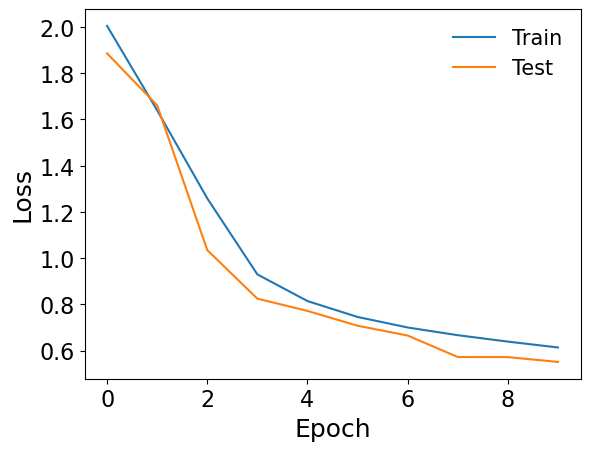

In [25]:
# Plot graph of loss values
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')

plt.ylabel('Loss', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

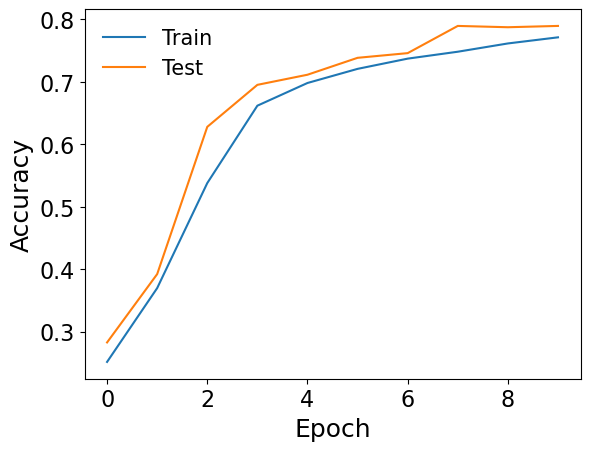

In [26]:
# Plot graph of accuracies
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')

plt.ylabel('Accuracy', fontsize = 18)
plt.yticks(fontsize=16)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(fontsize=16)
plt.legend(fontsize=15, frameon=False)

plt.show()

This looks like a decent training progression! It should improve even further with more training time and epochs.

## Inference

Now we can use the model for inference and also visualize predictions vs. ground truth as we have done often already. We will use the code from the introduction to ANN using PyTorch.

In [27]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

First, we make sure that we are using the best performing model so far. In contrast to what we did in connection with Object detection, where we saved the model as such, here we only saved its `state_dict`, so we have to instantiate the model first and then load the `state_dict` again:

In [28]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "ViT_model.pt")))
model.to(device)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=64, out_features=128, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_af

Let's start by obtaining the predictions for the 16 images of the first batch of the test set:

In [29]:
offset = 42
# test on images offset to offset+16 of the first set
batch_test = next(iter(test_loader))

preds, _ = predict_batch(model, batch_test[0][offset:offset+16], binary=False)

print(f'Predictions:\t\t {preds}')
print(f'Labels (ground truth):\t {batch_test[1][offset:offset+16]}')

Predictions:		 tensor([3, 9, 6, 9, 6, 3, 4, 2, 2, 2, 5, 2, 4, 2, 8, 4])
Labels (ground truth):	 tensor([3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4])


Now, let's visually check how well our model is doing:

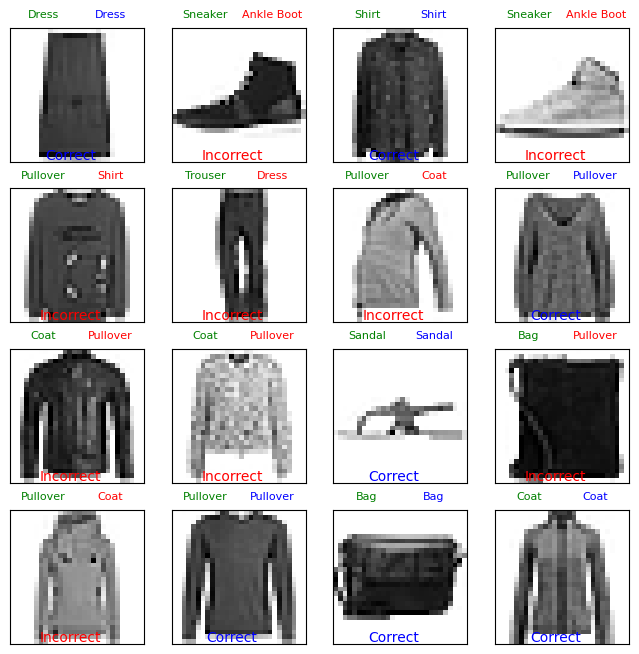

In [30]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        pred = preds[i]
        label = batch_test[1][offset+i]
        pred_txt = labels_map[int(pred)]
        label_txt = labels_map[int(label)]
        
        correct = pred == label
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][offset+i].view(28, 28)
        ax.imshow(img, cmap='gray_r');
        ax.text(0.25, 1.1, '{}'.format(label_txt), 
                size=8, color='green',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.75, 1.1, '{}'.format(pred_txt), 
                size=8, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.45, 0.05, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=10, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

### Final Notes

This implementation is a basic representation of how Vision Transformers work. The code structure is quite simple by design to be easier to follow. There are a lot of improvements and optimizations that could be made.

## Learning Outcomes
---
This material introduced transformer models and their core mechanism: attention. The theoretical foundation of such models is motivated in Natural Language Processing, but can, once understood, easily be transferred to vision tasks. This material also provides an implementation of the Vision Transformer model in PyTorch. If you paid *attention* to this notebook, you should now

* know the ideas behind transformer models, in particular
  * the attention mechanism with queries, keys, and values
  * why attention is scaled and normalized through softmax
  * encoder and decoder architectures
* understand the necessary modifications to work with image data
* be able to implement a Vision Transformer model with attention mechanism from scratch in PyTorch.